<a href="https://colab.research.google.com/github/iampatgrady/Colaboratory-Analytics-Demos/blob/master/GCP_Training_Twilio_C4M_Prefect_io_Controller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cloud for Marketing - Prefect.io Controller Demo

In [ ]:
#@title Install Libraries
#@markdown requires a runtime restart!
!pip install google-cloud-secret-manager
!pip install "prefect[sendgrid, google]"

In [ ]:
#@title Import Libraries and Authenticate
import prefect
from prefect import task, Flow, Parameter
from prefect.tasks.sendgrid import sendgrid
from google.cloud import secretmanager
import os
import pandas as pd
from google.colab import auth
auth.authenticate_user()

# Using Prefect, Sendgrid, and Google Secrets Manager


*   [Create a Prefect Cloud account](https://universal.prefect.io/signin/register) and [register an API key](https://docs.prefect.io/orchestration/concepts/api_keys.html#using-api-keys)
*   [Create a SendGrid account](https://sendgrid.com/pricing/) and [register an API key](https://app.sendgrid.com/settings/api_keys)
*   Store the above API keys in [Google Cloud Secrets Manager](https://cloud.google.com/secret-manager/docs/create-secret)
*   Enter the names of the secrets in the fields below:




In [ ]:
#@title Connect to Prefect Cloud tenant
# Create a Client:
client = secretmanager.SecretManagerServiceClient()
prefect_api_secret_name = "prefect-c4m-api-key" #@param {type:'string'}
sendgrid_api_secret_name = "sendgrid-c4m-demo-api-key" #@param {type:'string'}
gcp_project_id = 'cloud-for-marketing-demo' #@param {type:'string'}

# Forge the path to the latest version of your secret with an F-string:
resource_name = f"projects/{gcp_project_id}/secrets/{prefect_api_secret_name}/versions/latest" 

# Get your secret :
response = client.access_secret_version(request={"name": resource_name})
prefect_secret_string = response.payload.data.decode('UTF-8')
!prefect auth login --key $prefect_secret_string

# SendGrid Example
To use this example you must upload a CSV with the header as "emails" followed by rows of valid email addresses:  
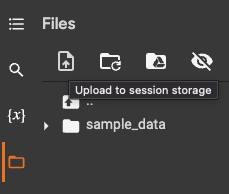


In [ ]:
#@title Create `email_task()` and register the flow with `c4m-demo` project
email_csv = "emails.csv" #@param {type:'string'}
email_subject = "Adswerve using Prefect + Sendgrid" #@param {type:'string'}
email_content = "Hi, how are you?  This is an email sent from my simple Prefect.io orchestration!" #@param {type:'string'}
resource_name = f"projects/{gcp_project_id}/secrets/{sendgrid_api_secret_name}/versions/latest" 
# Get your secret :
response = client.access_secret_version(request={"name": resource_name})
sendgrid_secret_string = response.payload.data.decode('UTF-8')

@task
def get_emails():
  logger = prefect.context.get("logger")
  logger.info("Starting email_task()")
  email_df = pd.read_csv(email_csv)
  logger.info(f"Found {len(email_df)} emails.")
  return list(email_df.emails.values)

@task
def email_task(emails):
  logger = prefect.context.get("logger")
  logger.info("Starting email_task()")
  emailer = sendgrid.SendEmail(
      from_email="pat.grady@adswerve.com", 
      to_emails=emails, 
      subject=email_subject, 
      html_content=email_content, 
      sendgrid_api_key=sendgrid_secret_string
  )
  resp = emailer.run()
  logger.info(f"email_task() HTTP status: {resp.status_code}")
  return (resp.status_code, emails)

@task
def log_task(input):
  logger = prefect.context.get("logger")
  logger.info(f"Email Status: {input[0]} for emails: {input[1]}")
  

with Flow("email-flow") as flow:
  emails = get_emails()
  email_status = email_task(emails)
  log_task(email_status)

flow.register(project_name="c4m-demo")

In [ ]:
!prefect agent local start

## After running the agent, go to Prefect Cloud and Run the `email_flow` job!
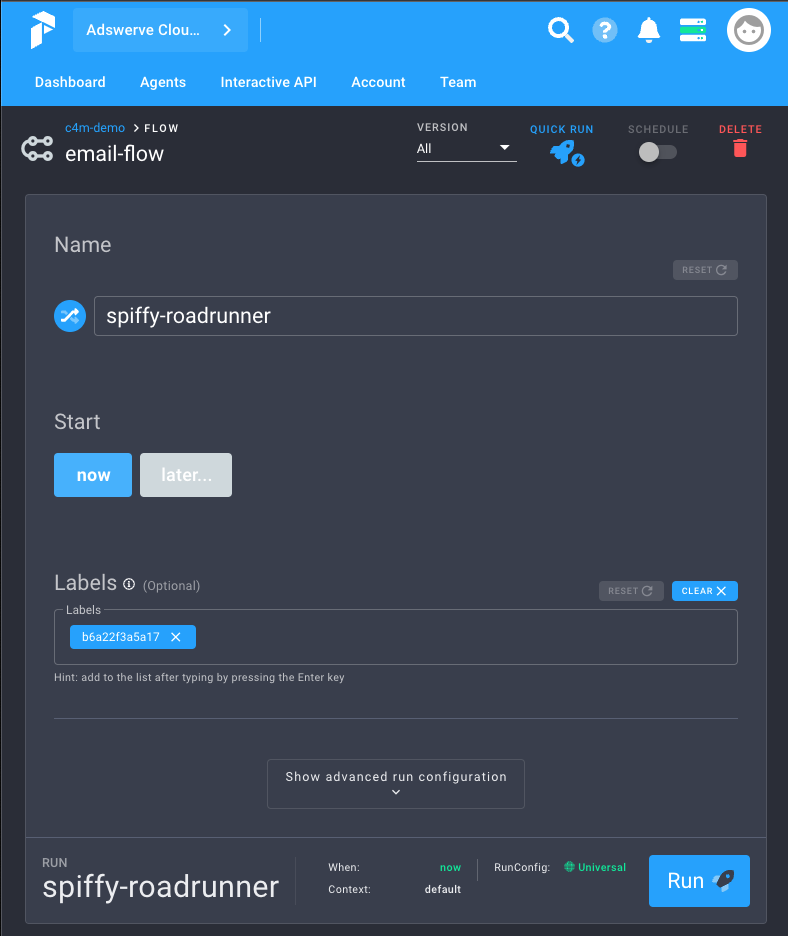

## Then check your email 😊